<a href="https://colab.research.google.com/github/Samarth-991/Face-Detection/blob/master/Face_Expression-Detection_FASTAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Face Expression Dataset with Fast-AI 2

In [1]:
# !pip install kaggle
# !pip install tpot
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
# ! unzip /content/face-expression-recognition-dataset.zip
# ! rm -rf /content/face-expression-recognition-dataset.zip

In [2]:
import glob
import os
import gc
import tensorflow as tf 
import numpy as np
import pandas as pd
import time
import cv2
import os
import glob
import random
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array

In [3]:
# !pip install -Uqq fastbook
# !pip install fastai
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

In [4]:
data_path = "/content/images/"
Train_path = os.path.join(data_path,'train')
Valid_path = os.path.join(data_path,'validation')
Train_data = []
Valid_data = []
for subdir, dirs, files in os.walk(Train_path):
  for filename in files:
    filepath = subdir + os.sep + filename
    Train_data.append((filename,os.path.split(subdir)[1]))

for subdir ,dirs ,files in os.walk(Valid_path):
  for filename in files : 
    Valid_data.append((filename,os.path.split(subdir)[1]))

print("training files : ",len(Train_data))
print("Validation files: ",len(Valid_data))

training files :  28821
Validation files:  7066


In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 96
IMG_WIDTH = 96
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
EPOCHS = 10
INIT_LR = 1e-3
STEPS_PER_EPOCH = len(Train_data)//BATCH_SIZE


In [6]:
def generate_imgdataframe(data,save_as='train.csv',base_path=None):
    labels = []
    filenames = []
    image_shape = []
    for imgfile,label in data:
        imgfile=os.path.join(label,imgfile)
        if base_path:
            imgfile = os.path.join(base_path,imgfile)
        img = plt.imread(imgfile)
        image_shape.append(img.shape)
        labels.append(label)
        filenames.append(imgfile)
    df = pd.DataFrame({'filename':filenames,'Class':labels,'shape':image_shape})
    df.to_csv(save_as)
    return df
train_df = generate_imgdataframe(Train_data,base_path=Train_path)

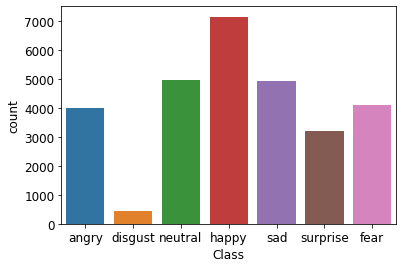

In [7]:
sns.countplot(x=train_df.Class)

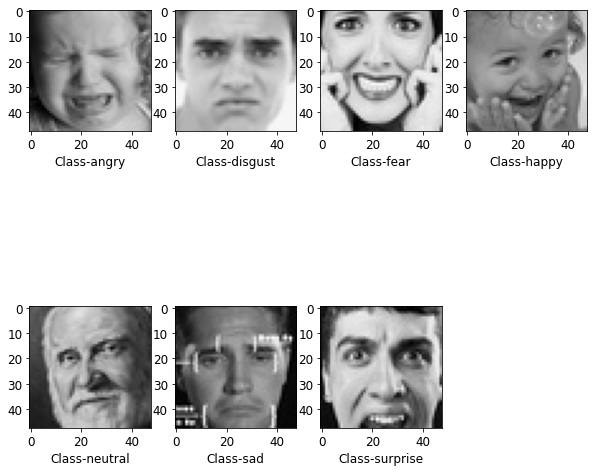

In [8]:
df = train_df.groupby(['Class'])['filename']
imgs_perId = []
for id , name in df:
    img_path = os.path.join(str(id),name[random.choice(name.index)])
    imgs_perId.append(img_path)

# Display Multiple images in a matix 
fig=plt.figure(figsize=(10, 10))
fig.tight_layout()
columns = 4
rows = 2
for i in range(1, columns*rows):
    img = cv2.imread(imgs_perId[i-1])
    fig.add_subplot(rows, columns, i,xlabel="Class-"+imgs_perId[i-1].split('/')[-2])
    plt.imshow(img)

In [9]:
# We are creating a fastai DataBunch from our dataset
# Preprocessing takes place when creating the databunch
# May need to decrease batch size and num_workers depending on GPU
data = ImageDataLoaders.from_folder(data_path, train='train', valid='validation', ds_tfms=aug_transforms(do_flip=False,flip_vert=True),size=96, bs=64, num_workers=8)

NUmber of calsses 7
Training data 28821 
Test data 7066 



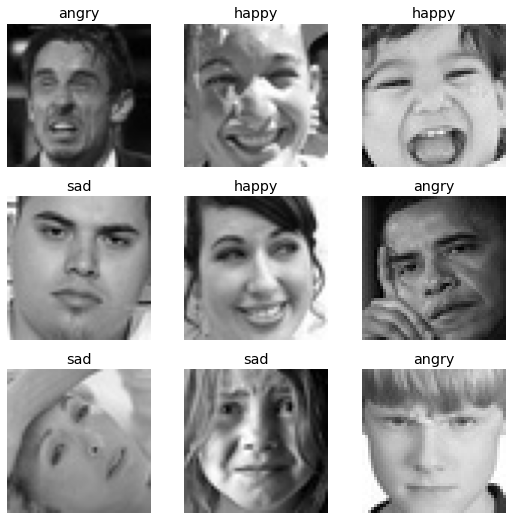

In [10]:
# Show what the data looks like after being transformed
data.show_batch()
# See the classes and count of classes in your dataset
print("NUmber of calsses",data.c)
# See the number of images in each data set
print("Training data {} \nTest data {} \n".format(len(data.train_ds), len(data.valid_ds)))

In [11]:
# Build the CNN model with the pretrained resnet34
# Error rate = 1 - accuracy
learn = cnn_learner(data, models.resnet34, metrics = [accuracy])
# Train the model on 4 epochs of data at the default learning rate
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.078497,1.668021,0.369941,00:50
1,1.540209,1.440799,0.451175,00:50
2,1.420533,1.363517,0.480328,00:51
3,1.336760,1.341829,0.487546,00:51


##Validate Model Performance
One of the popular methods is using the confusion matrix. Diagonal values of the matrix indicate correct predictions for each class, whereas other cell values indicate a number of wrong predictions.

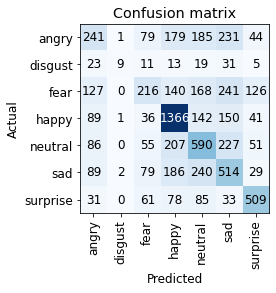

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Plot Top losses
function to see the wrong predictions based on the highest loss rate. The output of this function indicates the predicted label, target label, loss rate, and the probability value for each image. High probability indicates a high confidence level by the model. It varies between 0 and 1. A high loss rate indicates how bad the model performance is.

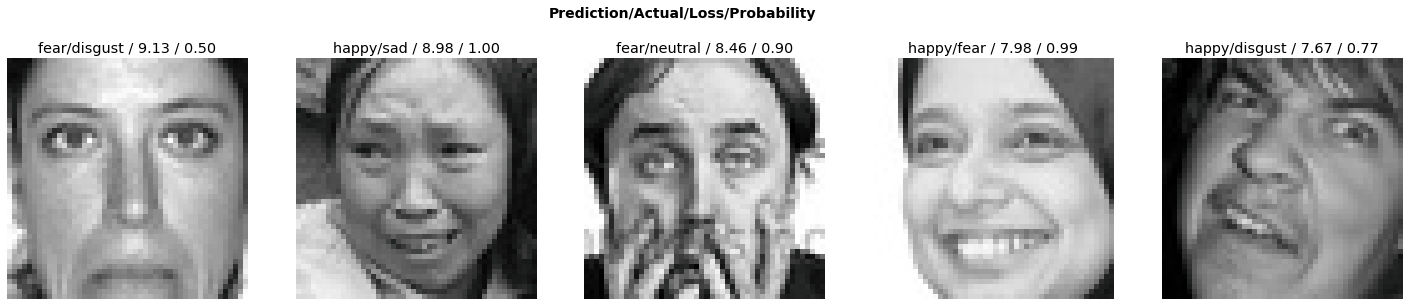

In [13]:
interp.plot_top_losses(5, nrows=1, figsize = (25,5))

In [14]:
# Save Model
learn.export('/content/Model/1_export.pkl')
# One more way to save the model
# Save the model --> learn.save('stage-1')

## Fine  Tunening
all the layers except the very last layer are frozen. When we called fit_one_cycle on these frozen layers we only trained the final layer which is the part that classifies 

epoch,train_loss,valid_loss,accuracy,time
0,1.590823,1.467122,0.490660,00:56
1,1.676243,1.886882,0.479621,00:55
2,1.472929,1.573393,0.473535,00:53
3,1.452149,1.564734,0.493773,00:55
4,1.217646,1.354989,0.497170,00:54
5,1.100358,1.135174,0.581942,00:55
6,1.027285,1.116647,0.605293,00:54
7,0.880126,1.101870,0.619304,00:57
8,0.744422,1.091130,0.618313,00:55
9,0.661255,1.224715,0.621144,00:54


SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=1.5848931980144698e-06)

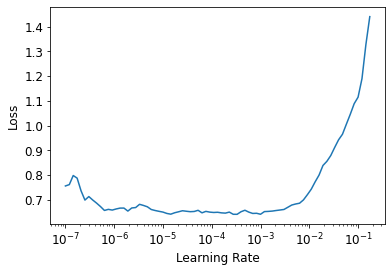

In [18]:
learn = cnn_learner(data, models.resnet34, metrics = [accuracy])
# fine tune the CNN Fit the model over 5 epochs
learn.unfreeze()
learn.fit_one_cycle(10,lr_max=10e-4)

# # Find the optimal learning rate and plot a visual
learn.lr_find()

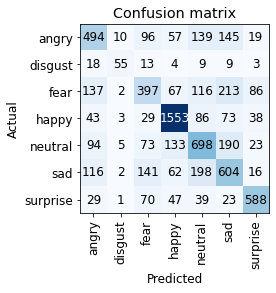

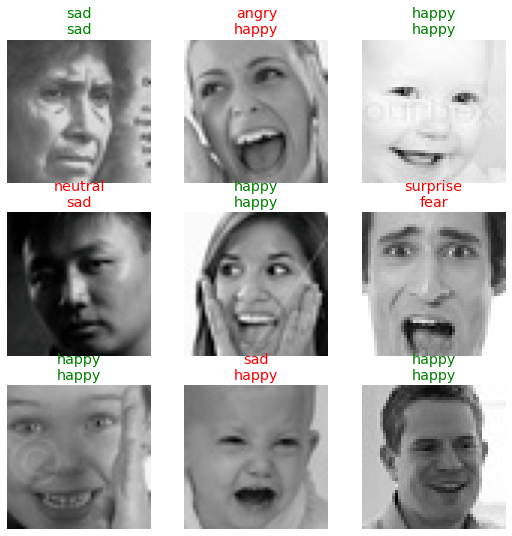

In [20]:
# Validating Perfromance 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
learn.show_results()

In [21]:
# Save Model
learn.export('/content/Model/2_export.pkl')

## Load the model

In [8]:
learn_inf = load_learner('/content/Model/2_export.pkl')
print(learn_inf.predict('/content/face-boy.jpg'))
print(learn_inf.dls.vocab)

('sad', tensor(5), tensor([8.6962e-03, 4.3157e-04, 2.8592e-01, 4.4264e-03, 3.4023e-02, 6.6419e-01, 2.3115e-03]))
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Deployment

In [10]:
btn_run = widgets.Button(description='Classify')
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [13]:
# https://github.com/RajiRai/FastAI/blob/master/Covid19_prediction_using_X_ray.ipynb